<a href="https://colab.research.google.com/github/hjornskar-ctrl/dim-clem/blob/main/Param_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Moving to a coherent analysis:

    Using the CBC model, build likelihood, prior and posterior functions for the network of gravitational-wave detectors.
    Maximise the likelihood function and plot relevant quantities.
    Interface the posterior function with a sampling algorithm.
        You are free to select any ready-made algorithm, or write your own. (will just use MCMC)
    Perform the sampling, and plot the results.
        This step can take a long time, and so it is best to develop and test first with a few sampling iterations, and not with the whole sampling run.
    Compare the results with the literature and discuss.


Going to do it with a single detector first

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
! pip install -q gwpy

In [ ]:
! pip install -q lalsuite pycbc

In [ ]:
from gwpy.timeseries import TimeSeries

/usr/local/lib/python3.11/dist-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


In [ ]:
from gwosc.datasets import event_gps

GW200129_065458

In [ ]:
time_centre = event_gps('GW200129_065458')

print(time_centre)

1264316116.4


In [ ]:
data={} # an empty dictionary
ifos=['L1','H1'] # a list which we use as the dictionary keys
for ifo in ['H1','L1']:
    data[ifo] = TimeSeries.fetch_open_data(ifo, time_centre - 16, time_centre +16)

In [ ]:
# Remove the low frequency content and downsample the data to 2048Hz
for ifo in ['H1','L1']:
    data[ifo] = data[ifo].highpass(15).resample(2048)

GOing to down sample for speed. In the paper, for CBC model parameter estimation, the sampling rate was also down sampled from 4096 Hz to 2048 Hz.

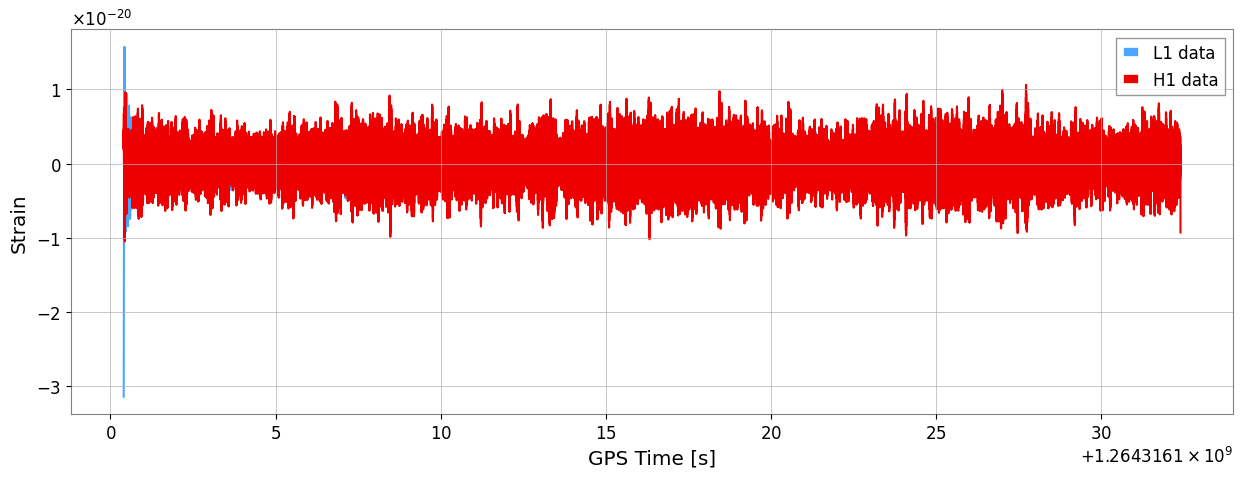

In [ ]:
plt.figure(figsize=(15,5))
colours=['gwpy:ligo-livingston','gwpy:ligo-hanford']
for ifo,colour in zip(ifos,colours):
    plt.plot(data[ifo],label='{} data'.format(ifo),color=colour)
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.legend();

The waveforms seem fairly similar, with the glitch in L1 as described in the paper being fairly obvious.

I'm not sure what to do about this...

The excess power from the glitch directly overlapping GW200129 in LIGO Livingston was subtracted before estimation of the signal’s source properties [1, 5] using the gwsubtract algorithm: https://arxiv.org/abs/1809.05348

In [ ]:
psd={}
for ifo in ifos:
    psd[ifo] = data[ifo].psd(fftlength=4)

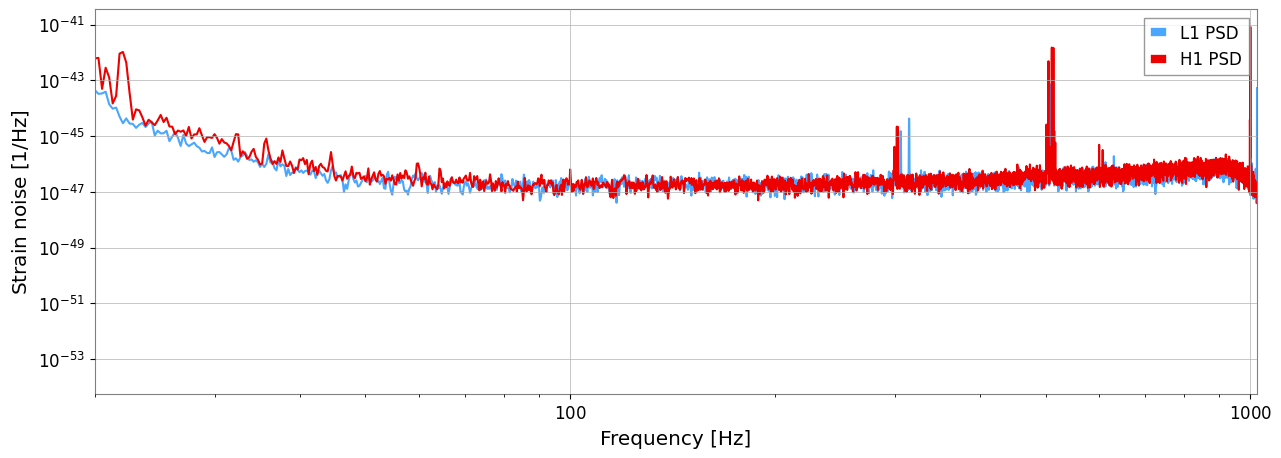

In [ ]:

plt.figure(figsize=(15,5))
for ifo,colour in zip(ifos,colours):
    plt.loglog(psd[ifo],label='{} PSD'.format(ifo),color=colour)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Strain noise [$1/\mathrm{Hz}$]')
plt.xlim(20,1024)
plt.legend();

PSD for both detectors. Spectral leakage becomes obvious below approximately ~60Hz due to larger variation in strain for each frequency bin. This occurs due to longer wavelength signals being more affected by the truncation applied by FFT when calculating the PSD. This necessitates band passing, since when whitening the data we want to focus on the regions which best represent the signal.

In [ ]:
from pycbc.waveform import get_td_waveform

Waveform systematics are expected to play a significant role in GW200129’s inference (e.g. Refs. [1, 14, 101]), which motivates utilizing NRSur7dq4 for all of our main text results.

It does not work :(

In [ ]:
from pycbc.waveform import td_approximants, fd_approximants

print(td_approximants())

['TaylorT1', 'TaylorT2', 'TaylorT3', 'SpinTaylorT1', 'SpinTaylorT4', 'SpinTaylorT5', 'PhenSpinTaylor', 'PhenSpinTaylorRD', 'EOBNRv2', 'EOBNRv2HM', 'TEOBResum_ROM', 'SEOBNRv1', 'SEOBNRv2', 'SEOBNRv2_opt', 'SEOBNRv3', 'SEOBNRv3_pert', 'SEOBNRv3_opt', 'SEOBNRv3_opt_rk4', 'SEOBNRv4', 'SEOBNRv4_opt', 'SEOBNRv4P', 'SEOBNRv4PHM', 'SEOBNRv2T', 'SEOBNRv4T', 'SEOBNRv4_ROM_NRTidalv2', 'SEOBNRv4_ROM_NRTidalv2_NSBH', 'HGimri', 'IMRPhenomA', 'IMRPhenomB', 'IMRPhenomC', 'IMRPhenomD', 'IMRPhenomD_NRTidalv2', 'IMRPhenomNSBH', 'IMRPhenomHM', 'IMRPhenomPv2', 'IMRPhenomPv2_NRTidal', 'IMRPhenomPv2_NRTidalv2', 'TaylorEt', 'TaylorT4', 'EccentricTD', 'SpinDominatedWf', 'NR_hdf5', 'NRSur7dq2', 'NRSur7dq4', 'SEOBNRv4HM', 'NRHybSur3dq8', 'IMRPhenomXAS', 'IMRPhenomXHM', 'IMRPhenomPv3', 'IMRPhenomPv3HM', 'IMRPhenomXP', 'IMRPhenomXPHM', 'TEOBResumS', 'IMRPhenomT', 'IMRPhenomTHM', 'IMRPhenomTP', 'IMRPhenomTPHM', 'SEOBNRv4HM_PA', 'pSEOBNRv4HM_PA', 'IMRPhenomXAS_NRTidalv2', 'IMRPhenomXP_NRTidalv2', 'IMRPhenomXO4a', 'E

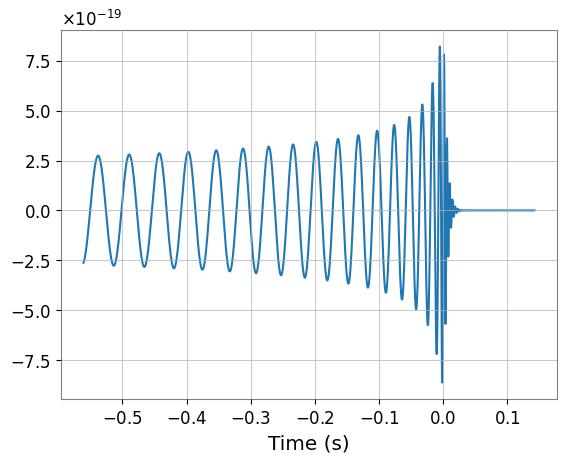

In [ ]:
m1 = 34.5 * (1 + 0.18)
m2 = 29 * (1 + 0.18)
hp, hc = get_td_waveform(approximant='SEOBNRv4_opt',
                          mass1=m1,
                          mass2=m2,
                          delta_t=data['H1'].dt.value,
                          f_lower=20)
plt.plot(hp.sample_times, hp)
plt.xlabel('Time (s)');

With two detectors we are potentially sensitive to more than a single polarization of gravitational
waves. We also have to account for the delay in the time of arrival of the signal based on where in
the sky the source may be located. This expands our parameters to be component mass (assuming
an equal mass binary), right ascension, declination, luminosity distance, inclination, merger time,
merger phase, and polarization angle.
For a give set of parameters⃗ 𝜆 we’ll now have to generate the plus and cross polarizations of the GW
emission (taking into account the inclination of the binary, and scaling to the proper distance), then
combine these with each detector’s antenna pattern (which depend on the location of the binary
relative to the detector’s orientation) to determine the detector response. Finally, we have to shift
the time of arrival of the signal to be consistent with the delay time expected based on the RA and
dec of the binary.

I didn't write this so will have to change!

In [ ]:
from pycbc.detector import Detector

In [ ]:
# Creating the detector objects:
det={}
for ifo in ifos:
    det[ifo]=Detector(ifo)

Ifo stands for interferometers, structring the data for the GW event into a parsable format from each detector.

In [ ]:
declination = 0
right_ascension = 5.5
polarization = 0.0 # uniform prior
fp={}
fc={}
for ifo in ifos:
    fp[ifo], fc[ifo] = det[ifo].antenna_pattern(right_ascension, declination,polarization, time_centre)
    print("{}: fp={}, fc={}".format(ifo,fp[ifo], fc[ifo]))

L1: fp=0.6744893702502468, fc=0.5331967726439342
H1: fp=-0.43843192801721637, fc=-0.5440881149926894


fp and fc are the antenna pattern functions. They are necessary for understanding plus-polsarisation and cross-polarisation responses for the interferometers at the time the signal arrived at both. This will evidently be different as H1 and L1 are at different locations. These parameters are very important in determining how much of both polarisations of the signal were detected by each interferometer, and therefore the GW sigal detected by each detector.


In [ ]:
ht={}
for ifo in ifos:
    ht[ifo] = fp[ifo] * hp + fc[ifo] * hc

With the antenna beam pattern functions we can then compute the gravitational-wave signal as
seen by each detector:

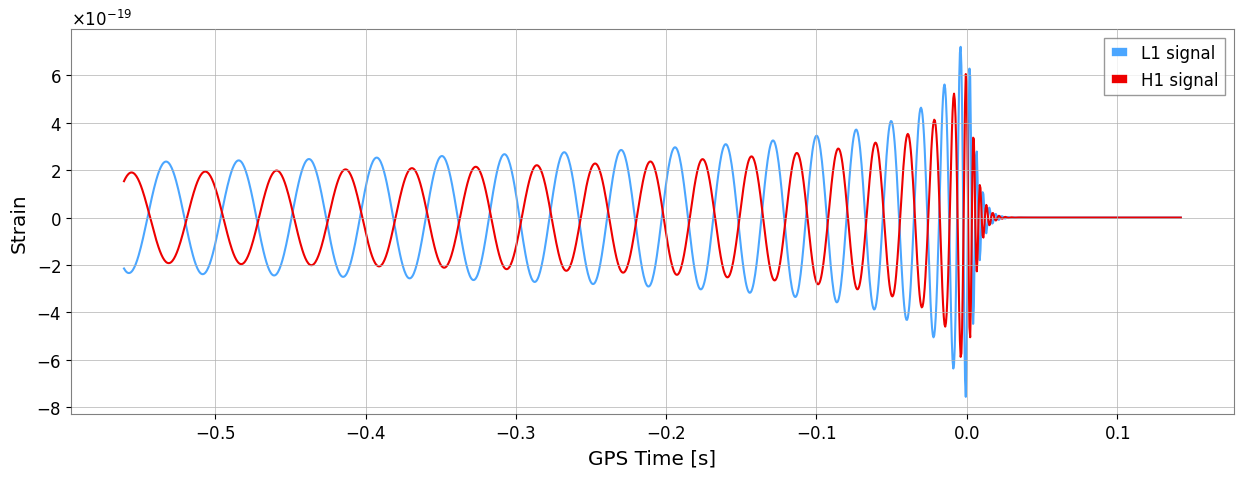

In [ ]:
plt.figure(figsize=(15,5))
for ifo,colour in zip(ifos,colours):
    plt.plot(TimeSeries.from_pycbc(ht[ifo]),label='{} signal'.format(ifo),color=colour)
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.legend()

'The rate of glitches at frequencies similar to the signal is much lower; using data from 4 days around the event, the rate of glitches with frequency 60-120 Hz is only 0.06/hr.'

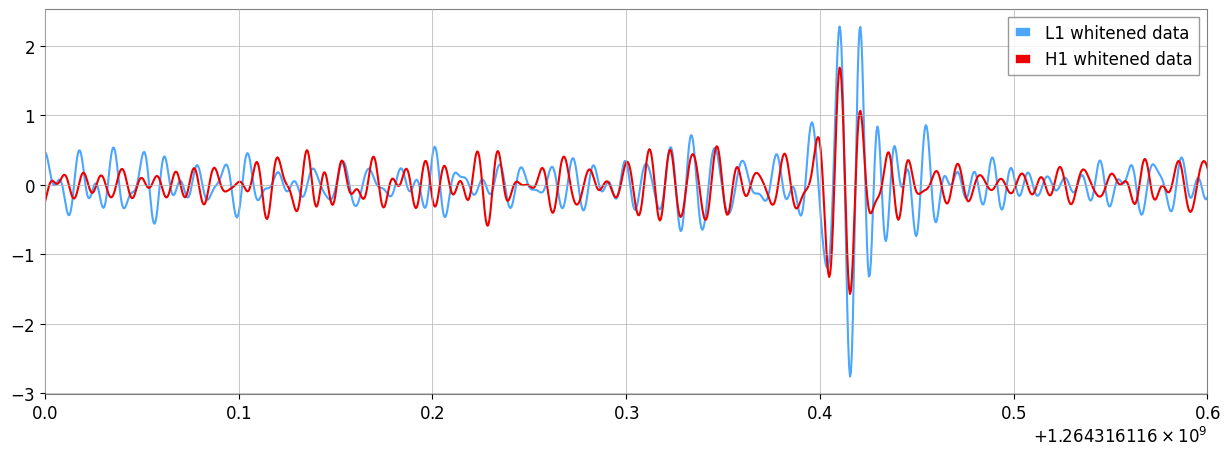

In [ ]:
plt.figure(figsize=(15,5))
white_data={}
for ifo,colour in zip(ifos,colours):
    white_data[ifo]=data[ifo].whiten(fftlength=4).bandpass(60,120)
    plt.plot(white_data[ifo],label='{} whitened data'.format(ifo),color=colour)
#plt.xlim(time_centre-4, time_centre+5.3)
plt.xlim(time_centre-0.4, time_centre+0.2)
plt.legend()

Above shows the whitened data for H1 and L1 strain data.

In [ ]:
time_delay=det['H1'].time_delay_from_earth_center(right_ascension, declination,time_centre)
print("For the sky-position ra={},dec={}, at time={},".format(right_ascension,declination,time_centre))
print("the time delay between Hanford and geocenter is {} seconds".format(time_delay))

For the sky-position ra=5.5,dec=0, at time=1264316116.4,
the time delay between Hanford and geocenter is 0.013537617427967502 seconds


Calculates the time delay between each detector.

As in chapter 7, we’ll make a light-weight wrapper for get_td_waveform() that will take parameter
vector⃗ 𝜆 and generate a waveform for us with the same sampling rate and time window as our data.
However, this time we need to project the “plus” and “cross” polarisations onto the detector arms

In [ ]:
for ifo in ifos:
    data[ifo]=data[ifo].crop(time_centre-2,time_centre+2)

In [ ]:
def gen_template(param,
    delta_t=data['H1'].dt.value, # Assuming all IFOs have the same dt
    duration=data['H1'].duration.value, # Assuming all IFOs have the same duration !
    start_time=data['H1'].x0.value,# Assuming all IFOs have the same start time !
    f_lower=20.):
    m1, m2, distance, time, phase, right_ascension, declination, inclination,polarization = param

    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                            mass1=m1,
                            mass2=m2,
                            distance=distance,
                            inclination=inclination,
                            coa_phase=phase,
                            delta_t=delta_t,
                            f_lower=f_lower)
  # Resize the signal buffer
    hp.resize(int(duration/delta_t))
    hc.resize(int(duration/delta_t))
    ht={}
    template={}
# compute the detectors responses and shift to the requested time
    for ifo in ifos:
        fp, fc = det[ifo].antenna_pattern(right_ascension, declination,polarization, time)
        ht[ifo] = fp * hp.copy() + fc * hc.copy()
        time_delay = det[ifo].time_delay_from_earth_center(right_ascension,declination, time)
        ht[ifo] = ht[ifo].cyclic_time_shift(ht[ifo].start_time + time - start_time + time_delay)
        ht[ifo].start_time=start_time
        template[ifo]=TimeSeries.from_pycbc(ht[ifo])
    return template

(1264316116.2, 1264316116.45)

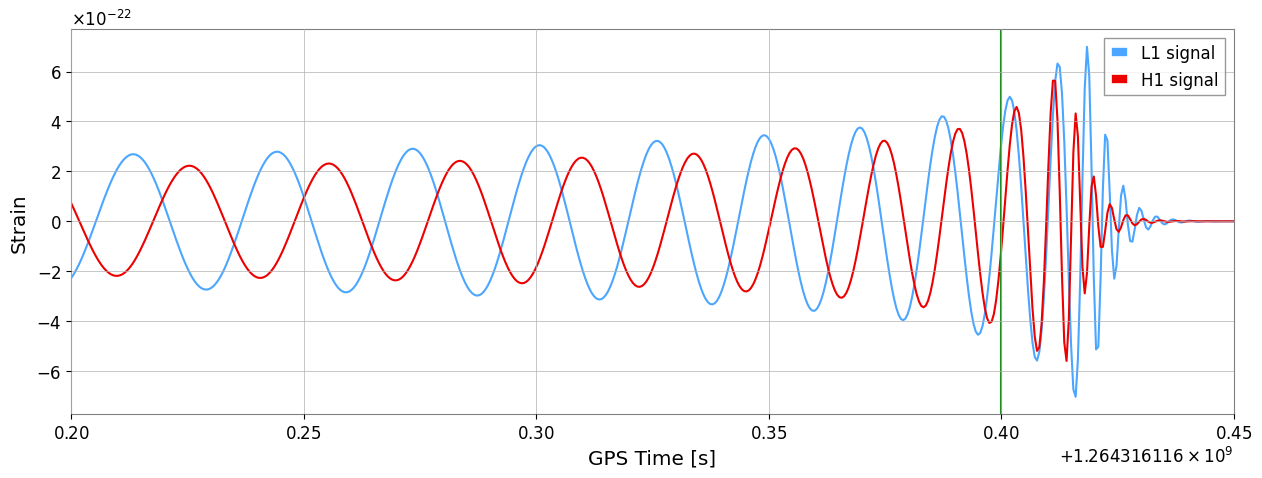

In [ ]:
# Testing the gen_template() function:
param=[34.5,29,890,1264316116.4,0.0,5.5, 0, 0.0, 0.]
# m1, m2, distance, time, phase, right_ascension, declination, inclination,polarization = param
template=gen_template(param)
plt.figure(figsize=(15,5))
for ifo,colour in zip(ifos,colours):
  plt.plot(template[ifo],label='{} signal'.format(ifo),color=colour)
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.legend();
plt.axvline(time_centre,c='forestgreen')
plt.xlim([time_centre-0.2,time_centre+0.05])

Calculates the CBC model for each detector with parameters taken from the paper.

With the network waveform generator now defined, we can define our likelihood function, which is
equivalent to the product of single-detector likelihood functions

To construct a likelihood function for the GW detector network (the two LIGO instruments in this
case), we will make the very reasonable assumption that noise is independent between detectors.
This means that our network likelihood fuction is just the product of single-detector likelihood
functions

In [ ]:
# FFT the data once, ahead of time
sf={}
for ifo in ifos:
    sf[ifo] = data[ifo].average_fft(window=('tukey',1./4.))*data[ifo].duration.value/2
def loglikelihood(param, sf=sf, f_lower=20.0):
    hf_hp = {}

    logl=0.0

    template = gen_template(param, delta_t=data['H1'].dt.value ,f_lower=f_lower)

    for ifo in ifos:
        # zero out the frequencies below f_lower
        sf_hp = sf[ifo].crop(start=f_lower)
        psd_hp = psd[ifo].crop(start=f_lower)

        hf = template[ifo].average_fft(window=('tukey',1./4.))*template[ifo].duration.value/2
        hf_hp = hf.crop(start=f_lower)

        h_dot_h = 4 * np.real((hf_hp * hf_hp.conjugate() / psd_hp).sum() *hf_hp.df)
        h_dot_s = 4 * np.real((sf_hp * hf_hp.conjugate() / psd_hp).sum() *sf_hp.df)

        logl += h_dot_s - h_dot_h/2
    return logl.value

-438.20232543784334


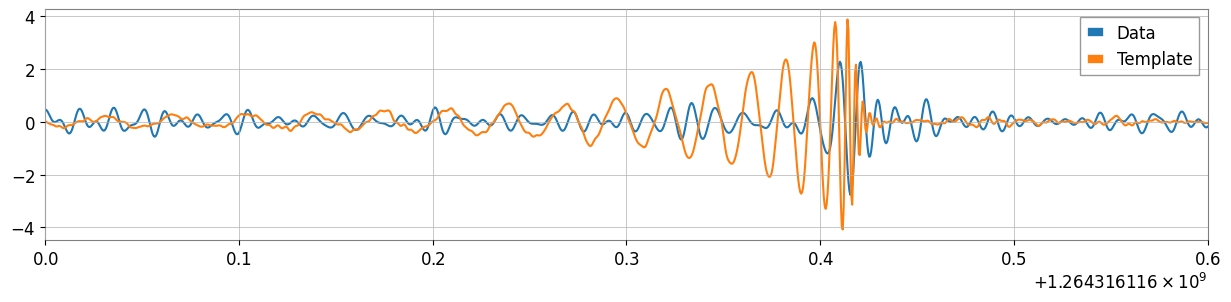

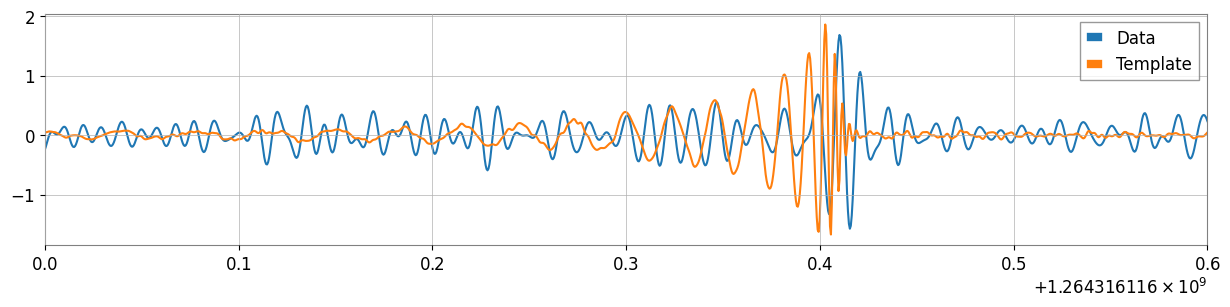

In [ ]:
param0=[34.5,29,890,1264316116.4,0.0,0, 0.0, 0.0, 0.]
# m1, m2, distance, time, phase, right_ascension, declination, inclination,polarization = param

template0 = gen_template(param0)

for ifo in ifos:
    white_template = template0[ifo].whiten(asd=np.sqrt(psd[ifo]),highpass=20.)

    plt.figure(figsize=[15, 3])
    plt.plot(white_data[ifo].times, white_data[ifo], label="Data")
    plt.plot(white_template.times, white_template, label="Template")
    plt.xlim(time_centre-0.4, time_centre+0.2)
    plt.legend();

print(loglikelihood(param0))

Now let’s maximize the likelihood to find the best-fit signal. We’ll use the minimize() function
provided by scipy using the Powell method, since it’s pretty good at dealing with non-smooth
functions. We’ll also define a callback function to print likelihood values and plot the model as it
works.

In [ ]:
from scipy.optimize import minimize
from IPython.display import display, clear_output

fig, axs = plt.subplots(2, 1, figsize=[15, 6])
Neval = 1

lines = {}
for ax, ifo in zip(axs, ifos):
    hite_template = template0[ifo].whiten(asd=np.sqrt(psd[ifo]),highpass=20.)

    ax.plot(white_data[ifo].times, white_data[ifo], label="Data")
    lines[ifo], = ax.plot(white_template.times, white_template, label="Template")

    ax.set_xlim(time_centre-.4, time_centre+.2)
    ax.legend()

def callback(param_i):
    global Neval
    global line
    global fig

    template = gen_template(param_i)
    for ifo in ifos:
        white_template = template[ifo].whiten(asd=np.sqrt(psd[ifo]),highpass=20.)
        lines[ifo].set_ydata(white_template)

    clear_output(wait=True)
    display(fig)
    print("Steps\tlog(likelihood)")
    print('{}\t{:.3f}'.format(Neval, loglikelihood(param_i)))

    Neval += 1

res = minimize(lambda param: -loglikelihood(param), param0, callback=callback, method='powell')
plt.close()


Key Components of the Code:

    Plot Setup (matplotlib):

        You are creating a figure with two subplots using fig, axs = plt.subplots(2, 1, figsize=[15, 6]), where you likely plan to visualize the data and template.

        For each interferometer (IFO), you plot the white_data and the white_template (the template you are fitting), and later update the template as the optimization proceeds.

    callback function:

        The callback function is called each time the optimization procedure evaluates a new set of parameters (param_i).

        It generates a new template using the current parameters, whitens it, and updates the plot.

        The log-likelihood is computed for the current parameters, and the number of evaluations (Neval) is printed along with the log-likelihood.

        The plot is updated in real-time to show how the template fits the data.

    minimize function:

        The minimize function from scipy.optimize is used to find the optimal parameters by minimizing the negative log-likelihood.

        The optimization method used here is powell, which is a derivative-free method. It's appropriate for cases where you don't have a gradient of the function.

        The lambda function lambda param: -loglikelihood(param) is passed to minimize, which represents the negative log-likelihood function to be minimized.

        The callback function is passed to minimize, which updates the plot and prints information during each evaluation.

    clear_output(wait=True) and display(fig):

        These lines clear the previous plot and display the updated one, ensuring that the plot is refreshed after each optimization step.

        clear_output(wait=True) is used to avoid flickering, and display(fig) re-renders the figure.

    Plotting:

        The template is whitened using the whiten() function, which removes noise by dividing by the noise power spectral density (psd), and a high-pass filter is applied at 20 Hz.

        You then plot the data (white_data[ifo]) and the current template (white_template), updating them iteratively.

Potential Issues or Considerations:

    Imports: You haven't included the import statements for matplotlib.pyplot (import matplotlib.pyplot as plt) and other libraries that may be required for this code to work. Ensure you have the necessary imports.

    Function Definitions: The functions gen_template and loglikelihood are assumed to be defined elsewhere in your code. Make sure these functions are implemented correctly as per your specific use case (likely related to gravitational wave data fitting).

    ifo and ifos: These variables are assumed to be predefined lists or dictionaries containing interferometer names (e.g., LIGO detectors). Make sure they are properly initialized before running this code.

    param0: The initial guess for the parameters (param0) isn't defined in the code you posted. Ensure that this is set to an appropriate value for your fitting problem.

In [ ]:
best_fit = res.x
best_fit_template = gen_template(best_fit) #best fit waveform found from optimisation of likelihood

Now let's subtract it from the data and see how consistent the residuals are with noise. We are using here the Q-transform to produce a high-resolution time-frequency map of the data:

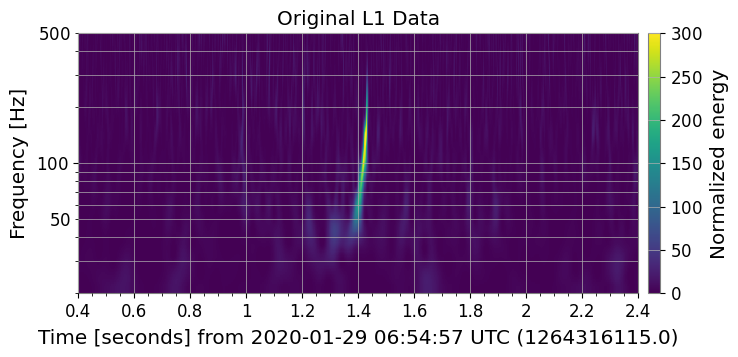

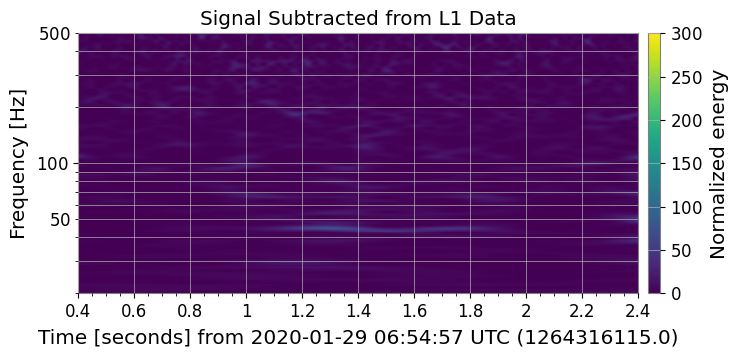

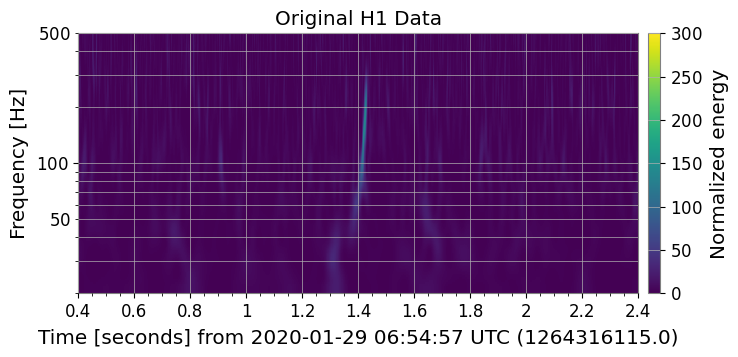

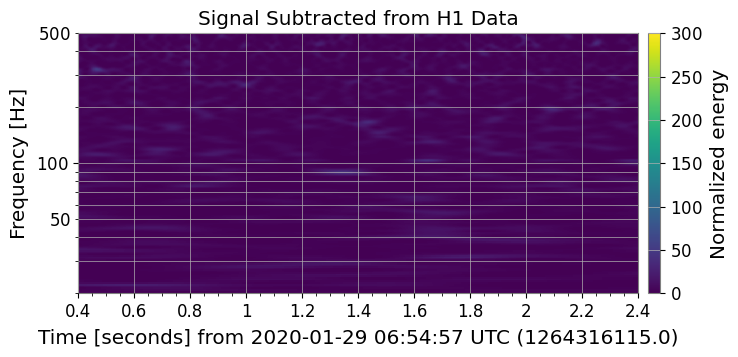

In [ ]:
for i, ifo in enumerate(ifos):
    subtracted = data[ifo] - best_fit_template[ifo]

    # Plot the original data and the subtracted signal data
    for d, title in [(data[ifo], 'Original {} Data'.format(ifo)),
                 (subtracted, 'Signal Subtracted from {} Data'.format(ifo))]:

        qspecgram=d.whiten(asd=np.sqrt(psd[ifo])).q_transform(outseg=(time_centre - 1, time_centre + 1),
                                                     frange=(20, 512))

        plot = qspecgram.plot(figsize=[8, 4],vmin=0,vmax=300)
        ax = plot.gca()
        ax.set_title(title)
        ax.set_xscale('seconds')
        ax.set_yscale('log')
        ax.set_ylim(20, 500)
        ax.set_ylabel('Frequency [Hz]')
        ax.grid(True, axis='y', which='both')
        ax.colorbar(cmap='viridis', label='Normalized energy')

As you can see above the generated waveform is successful as the residual between the data and generated waveform appears to be negligable.

Now let's make a model without any known priors (from the paper). We will assume a uniform prior since we don't know anything about the signal in this case.

In [ ]:
param0=[34.5,29,890,1264316116.4,0.0,0, 0.0, 0.001, 0.]

param=[34.5,29,890,1264316116.4,0.0,5.5, 0, 0.001, 0.]


In [ ]:
def logprior(param):
    # Unpack parameters
    m1, m2, distance, time, phase, ra, dec, inclination, polarization = param

    # Enforce ordering of masses
    if m1 < m2 or m1 <= 5 or m2 <= 5:  # Ensure m1 >= m2 and reasonable limits
        return -np.inf

    # Apply Gaussian prior on masses (adjust mean & std as needed)
    mu_m1, sigma_m1 = 30, 15  # Mean and std for m1
    mu_m2, sigma_m2 = 20, 12  # Mean and std for m2
    logprior_m1 = -0.5 * ((m1 - mu_m1) / sigma_m1) ** 2
    logprior_m2 = -0.5 * ((m2 - mu_m2) / sigma_m2) ** 2

    # Apply inclination prior (sin distribution)
    logprior_inclination = np.log(np.sin(inclination)) if 0 < inclination < np.pi else -np.inf

    # Apply power-law prior for distance
    d_max = 5000  # Max reasonable distance in Mpc
    if distance > d_max or distance <= 0:
        return -np.inf
    logprior_distance = -((distance - d_max) / 500) ** 2 if distance > d_max else 0  # Smooth cutoff

    # Check valid ranges for angles
    for angle in [ra, phase, polarization]:
        if not (0 <= angle <= 2 * np.pi):
            return -np.inf

    if not (-np.pi / 2 <= dec <= np.pi / 2):
        return -np.inf

    # Sum all priors
    return logprior_m1 + logprior_m2 + logprior_inclination + logprior_distance


With network likelihood and prior defined we can now take their product to get the posterior.

In [ ]:
def logposterior(param):
    logprior_val = logprior(param)

    # Reject invalid parameter values immediately
    if logprior_val == -np.inf:
        return -np.inf  # Reject sample

    loglikelihood_val = loglikelihood(param)

    # Check for NaNs in likelihood (e.g., numerical issues)
    if np.isnan(loglikelihood_val):
        return -np.inf

    return logprior_val + loglikelihood_val

In [ ]:
logposterior(param0)

np.float64(-445.4358556763417)



We can now maximize the posterior to determine the maximum a posteriori (MAP) parameters.

Where the maximum likelihood point was the "best fit" in the sense that it found the parameters that produced a model most consistent with the data, the MAP is more of a "best guess" in that it balances fitting the data with being consistent with prior expectations for source parameters.

However, as the posterior is a density, the MAP does depend on the parametrisation we chose.


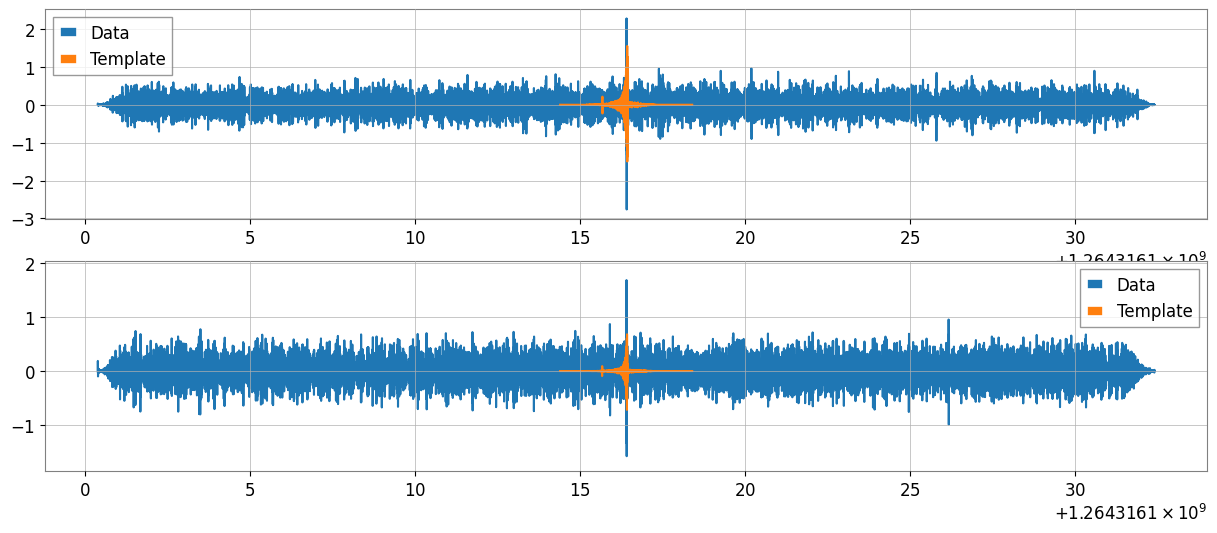

Steps	log(posterior)
16	74.312


In [ ]:
from scipy.optimize import minimize
from IPython.display import display, clear_output


fig, axs = plt.subplots(2, 1, figsize=[15, 6])
Neval = 1

lines = {}
for ax, ifo in zip(axs, ifos):
    hite_template = template0[ifo].whiten(asd=np.sqrt(psd[ifo]),highpass=20.)

    ax.plot(white_data[ifo].times, white_data[ifo], label="Data")
    lines[ifo], = ax.plot(white_template.times, white_template, label="Template")

    ax.set_xlim(time_centre-.4, time_centre+.2)
    ax.legend()

def callback(param_i):
    global Neval
    global line
    global fig

    template = gen_template(param_i)
    for ifo in ifos:
        white_template = template[ifo].whiten(asd=np.sqrt(psd[ifo]),highpass=20.)
        lines[ifo].set_ydata(white_template)

    clear_output(wait=True)
    display(fig)
    print("Steps\tlog(posterior)")
    print('{}\t{:.3f}'.format(Neval, logposterior(param_i)))

    Neval += 1

res = minimize(lambda param: -logposterior(param), param0, callback=callback, method='powell')
plt.close()

In [ ]:
best_guess = res.x
print(best_guess)

[ 3.51036910e+01  2.90690165e+01  2.39917104e+03  1.26431612e+09
  4.40347150e-02  9.53397150e-14 -2.42845431e-02  1.18489926e-02
  1.42452043e-03]


In [ ]:
pip install emcee


In [ ]:
pip install corner

If you want to run a small test sample before committing to a full MCMC run, you can do the following:
Key Adjustments for a Small Sample

    Reduce the number of steps (nsteps): Instead of 2000, try 100 or 200 to test quickly.

    Reduce the number of walkers (nwalkers): Instead of 3 * ndim, try 2 * ndim or even ndim + 1.

    Run fewer burn-in steps: Since it's a test, use discard=50 instead of 1000.

    Thin less aggressively: Instead of thin=10, use thin=2 so you don't discard too much data.

    Print intermediate results to check progress.

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 100/100 [11:08<00:00,  6.69s/it]


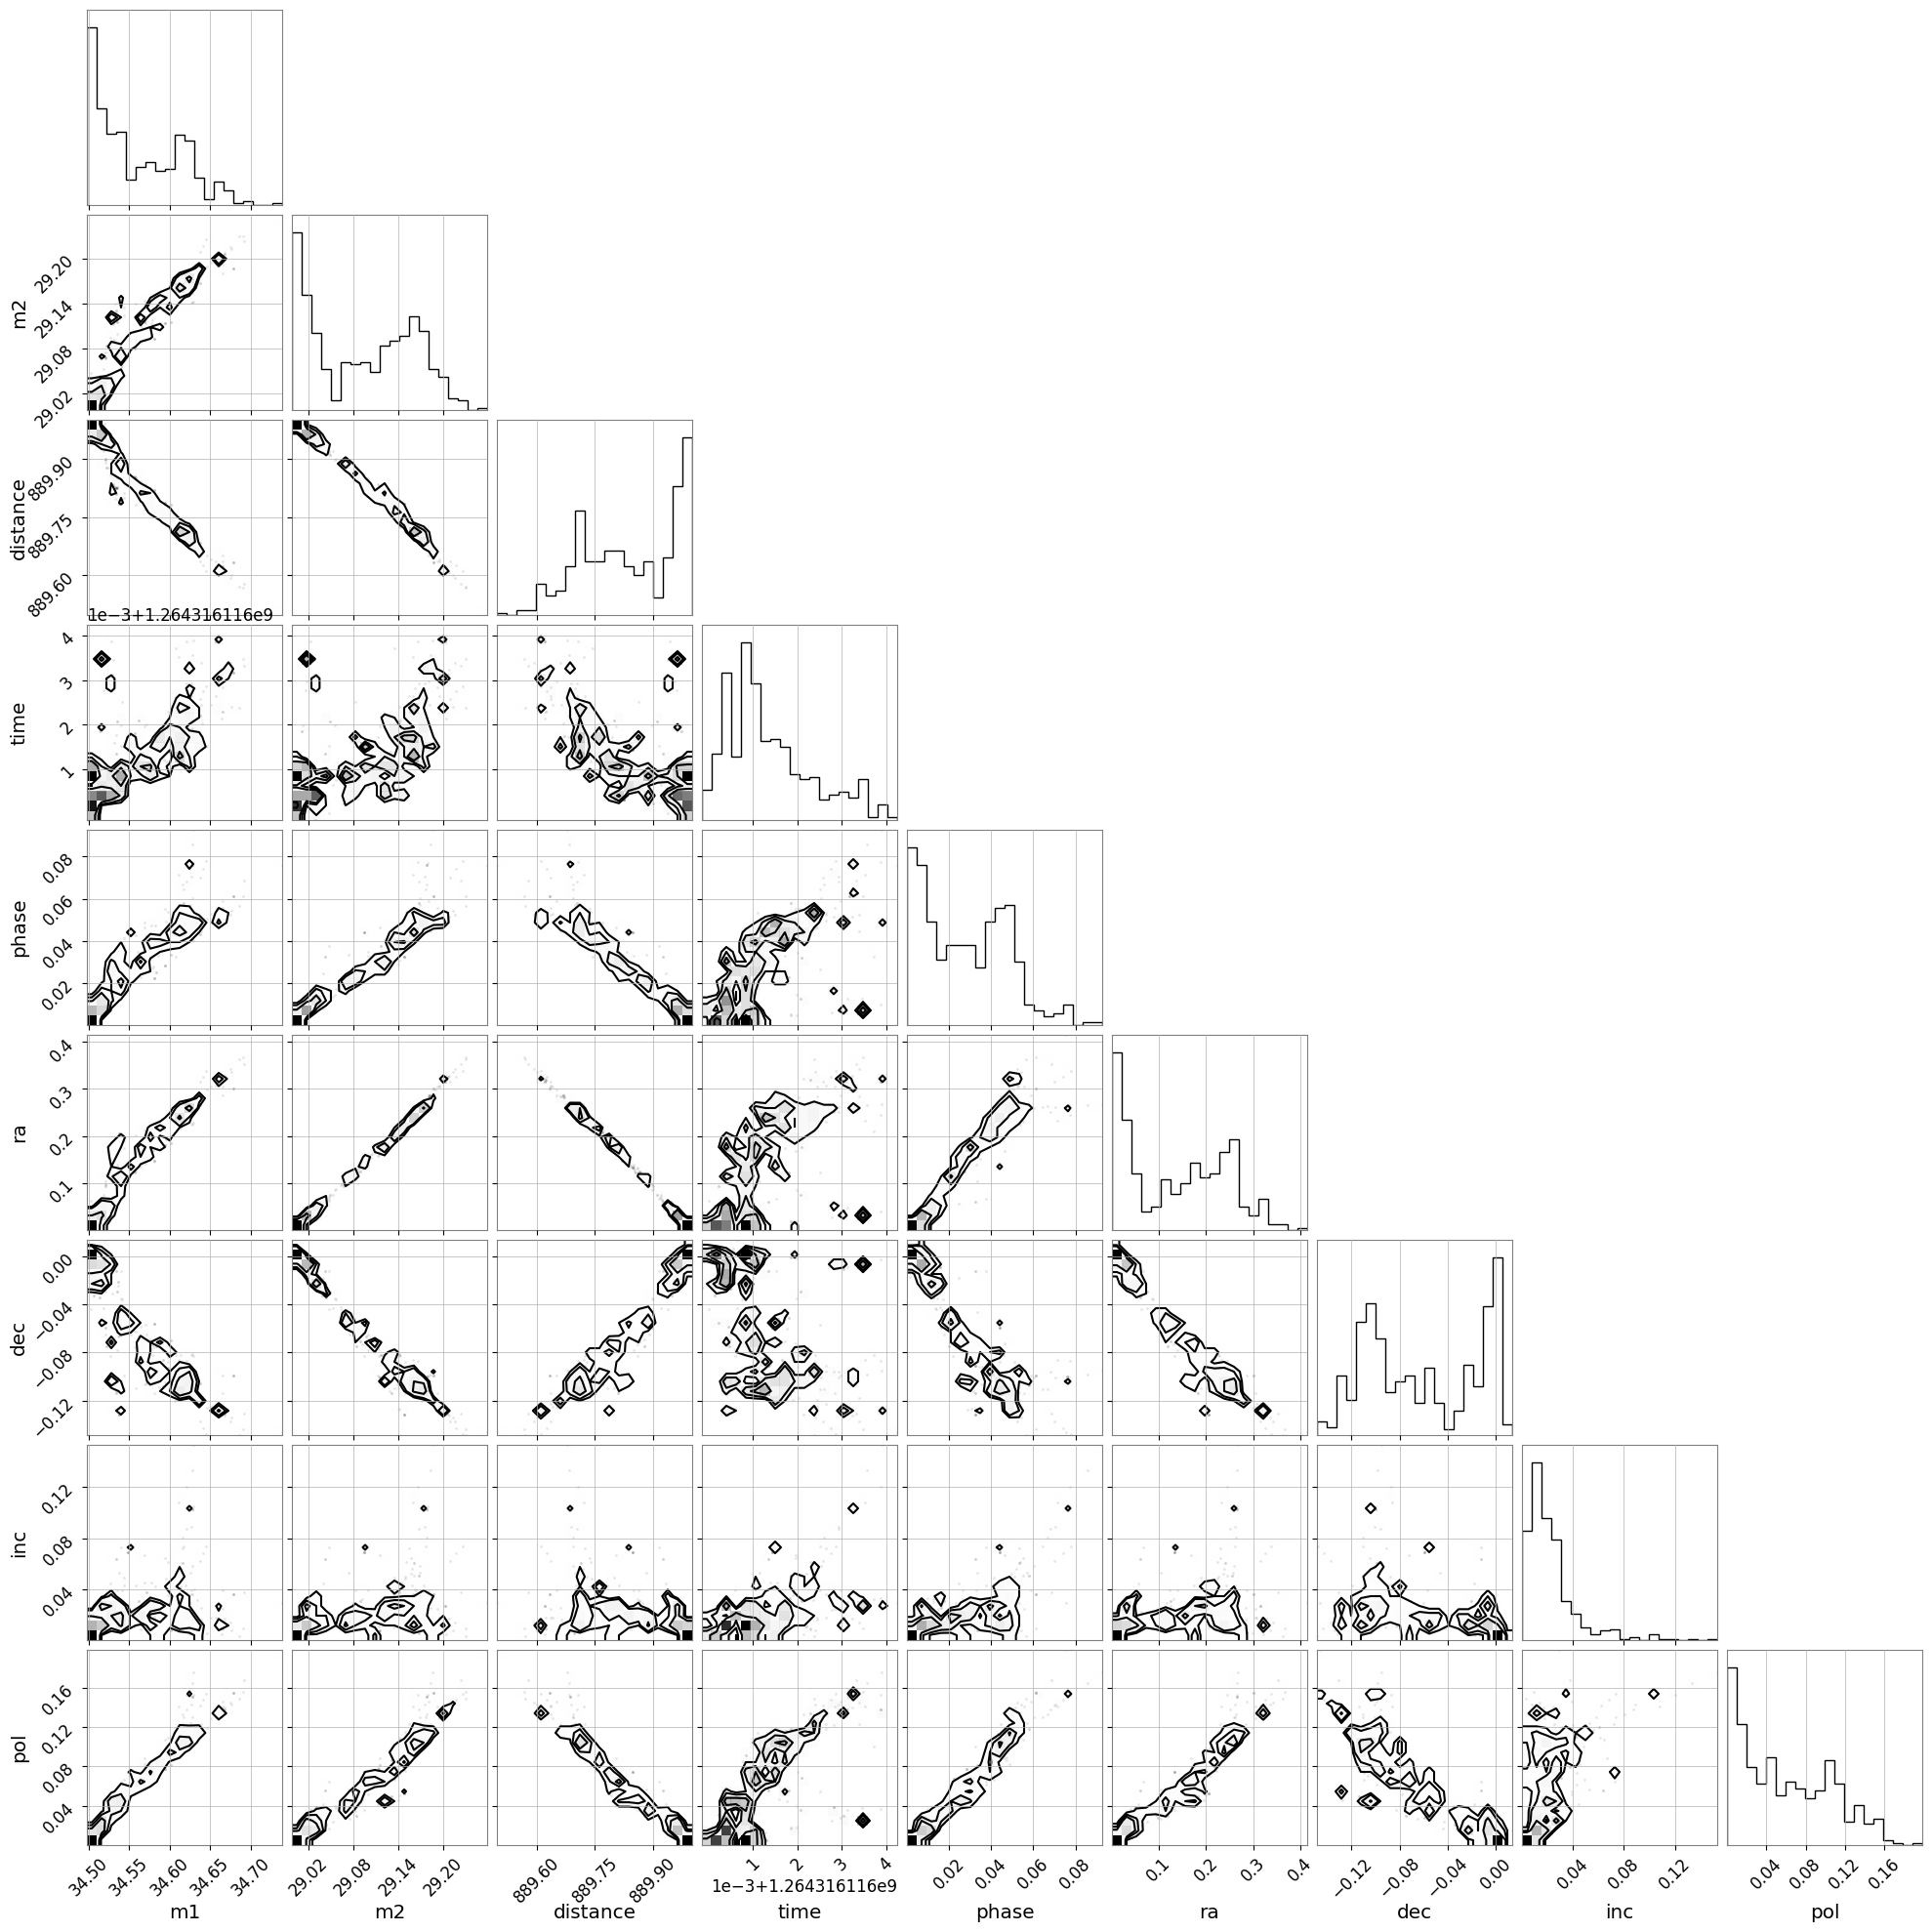

In [ ]:

import emcee
import numpy as np
import matplotlib.pyplot as plt
import corner


# Number of dimensions (parameters)
ndim = len(param0)  # Assuming param0 is your initial guess

# Number of walkers (chains) - typically 2-3 times ndim
nwalkers = 2 * ndim

# Initialize walkers near the previous best-fit (add small noise)
p0 = [param0 + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]

# Set up the MCMC sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, logposterior)

# Run the MCMC chain
nsteps = 100  # Increase if needed
sampler.run_mcmc(p0, nsteps, progress=True)

# Extract samples
samples = sampler.get_chain(discard=50, thin=2, flat=True)  # Burn-in & thinning

# Plot corner plot to visualize parameter distributions
fig = corner.corner(samples, labels=["m1", "m2", "distance", "time", "phase", "ra", "dec", "inc", "pol"])
plt.show()


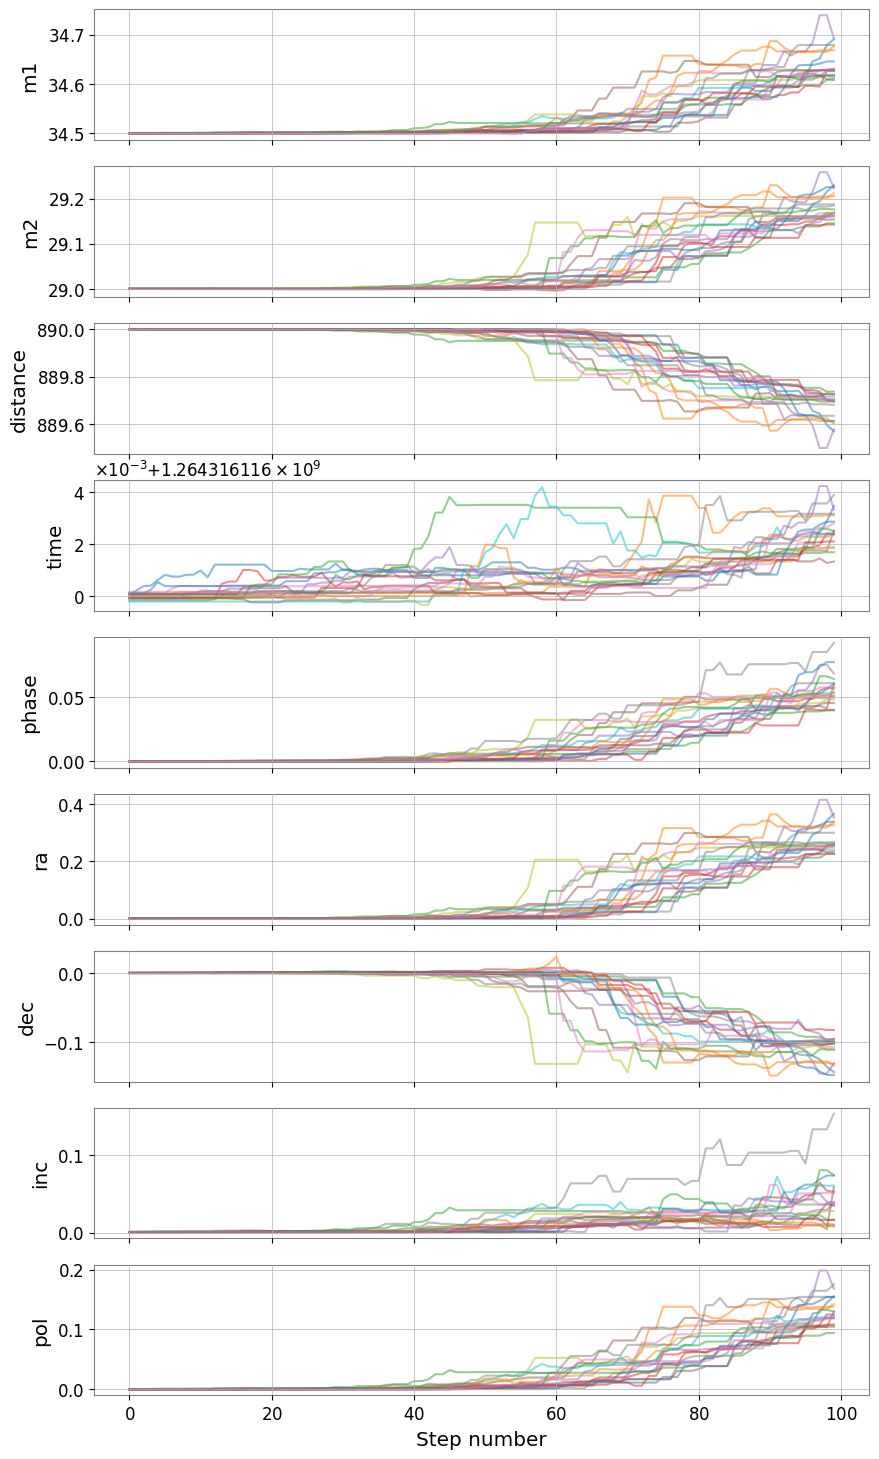

In [ ]:
samples = sampler.get_chain()

# Plot chains for each parameter
fig, axes = plt.subplots(ndim, figsize=(10, ndim * 2), sharex=True)
labels = ["m1", "m2", "distance", "time", "phase", "ra", "dec", "inc", "pol"]

for i in range(ndim):
    axes[i].plot(samples[:, :, i], alpha=0.5)
    axes[i].set_ylabel(labels[i])

axes[-1].set_xlabel("Step number")
plt.show()